In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV

def load_data(dataset_folders):
    combined_data = []
    for folder in dataset_folders:  # Update with the path to your datasets
        for filename in os.listdir(folder):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder, filename)
                # print(f"Loading {filepath}")
                participant_data = pd.read_csv(filepath)
                combined_data.append(participant_data)
    return pd.concat(combined_data, ignore_index=True)

# Hyperparameter grids
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Grid search with cross-validation
def perform_grid_search(estimator, param_grid, X, y, scoring='accuracy', cv=5):
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring, cv=cv, verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    return grid_search.best_estimator_

def train_test_split_by_participant(data, test_size=0.2):
    """Split data by participant for age and gender models."""
    participants = data['Participant'].unique()
    np.random.shuffle(participants)
    test_size = int(len(participants) * test_size)
    test_participants = participants[-test_size:]
    train_participants = participants[:-test_size]

    train_data = data[data['Participant'].isin(train_participants)]
    test_data = data[data['Participant'].isin(test_participants)]

    # Detailed split information
    print("Training on participants from databases:\n", train_data[['Participant', 'Database']].drop_duplicates())
    print("Testing on participants from databases:\n", test_data[['Participant', 'Database']].drop_duplicates())
    return train_data, test_data

def time_series_split(data, test_ratio=0.2):
    """Time-series split for participant ID identification."""
    train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
    test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)
    
    # Detailed split information
    for participant, group in data.groupby('Participant'):
        train_end = int(len(group)*(1-test_ratio))
        # print(f"Participant {participant} from {group['Database'].iloc[0]}: Train indices 0 to {train_end}, Test indices {train_end} to {len(group)}")
    return train_data, test_data

def prepare_features_labels(data, label_column, encode=True):
    """Prepare features and labels for training."""
    features = data.drop(columns=['Participant', 'Sample', 'Sampling_Rate', 'Database', 'Gender', 'Age', 'age_binned'])
    labels = data[label_column]
    if encode:
        encoder = LabelEncoder()
        labels = encoder.fit_transform(labels)
    return features, labels

def run_shap_analysis(model, X_train, X_test, model_name, task):
    # Using TreeExplainer for faster computation with tree-based models
    explainer = shap.TreeExplainer(model)

    # Sample a subset of data if X_test is too large
    if len(X_test) > 1000:  # Arbitrary threshold
        X_test_sample = X_test.sample(n=1000, random_state=42)
    else:
        X_test_sample = X_test

    # Calculate SHAP values for the sampled test set
    shap_values = explainer.shap_values(X_test_sample)

    # Ensure that X_test_sample is a DataFrame with feature names
    if not isinstance(X_test_sample, pd.DataFrame):
        X_test_sample = pd.DataFrame(X_test_sample, columns=[f"Feature_{i}" for i in range(X_test_sample.shape[1])])

    # Plot and save the summary bar plot
    plt.figure(20, 10)
    shap.summary_plot(shap_values, features=X_test_sample, feature_names=X_test_sample.columns, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot (Bar) - {model_name} for {task}')
    plt.savefig(f'plot/{model_name}_{task}_shap_summary_bar.pdf')
    plt.close()

    # Detailed SHAP summary plot
    plt.figure(20, 10)
    shap.summary_plot(shap_values, features=X_test_sample, feature_names=X_test_sample.columns, show=False)
    plt.title(f'SHAP Detailed Summary Plot - {model_name} for {task}')
    plt.savefig(f'plot/{model_name}_{task}_shap_detailed.pdf')
    plt.close()
    
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, task):
    if model_name == 'Logistic Regression':
        model = perform_grid_search(model, param_grid_lr, X_train, y_train)
    elif model_name == 'Decision Tree':
        model = perform_grid_search(model, param_grid_dt, X_train, y_train)
    elif model_name == 'Random Forest':
        model = perform_grid_search(model, param_grid_rf, X_train, y_train)
    # model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    classes = np.unique(np.concatenate([y_train, y_test]))

    print(f"Shapes - Predictions: {predictions.shape}, Probabilities: {probabilities.shape}")

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    try:
        if probabilities.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, probabilities[:, 1])
        else:
            # Binarize the output
            y_test_bin = label_binarize(y_test, classes=classes)
            roc_auc = roc_auc_score(y_test_bin, probabilities, multi_class='ovr')
    except Exception as e:
        roc_auc = None
        print(f"ROC AUC could not be calculated: {e}")

    print("Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, predictions)
    if task == 'Participant ID':
        plt.figure(figsize=(72, 54))
    else: 
        plt.figure(figsize=(12, 9))
        
    threshold = np.percentile(cm, 90)  # Adjust the percentile threshold
    mask = cm < threshold
    masked_confusion_matrix = np.where(mask, np.nan, cm)  
    sns.heatmap(masked_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title(f'Confusion Matrix for {model_name} on {task}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'plot/Confusion_Matrix_{model_name}_{task}.pdf')  # Save the confusion matrix figure
    plt.show()

    if probabilities.shape[1] == 2:  # Only plot ROC for binary classification
        fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name} on {task}')
        plt.legend(loc="lower right")
        plt.savefig(f'plot/{model_name}_{task}_ROC_Curve.pdf')  # Save the confusion matrix figure
        plt.show()
        
    # SHAP analysis
    try:
        run_shap_analysis(model, X_train, X_test, model_name, task)
    except Exception as e:
        print(f"SHAP analysis failed: {e} on {task} with model {model_name}")
        



In [7]:
# Main experiment setup
dataset_paths = ['mit-bih_features/', 'mit-long_features/', 'smart_features/', 'chfdb_features/', 'brno_features/']
combined_data = load_data(dataset_paths)
# drop the 'Half Minute' column
combined_data = combined_data.drop(columns=['Half Minute'])
combined_data['Gender'] = combined_data['Gender'].replace({'m': 'M'})

combined_data = combined_data.dropna()
unique_genders = combined_data['Gender'].unique()

age_bins = [0, 18, 35, 50, 65, 80, 100]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]

combined_data['age_binned'] = pd.cut(combined_data['Age'], bins=age_bins, labels=age_labels, right=False)
le = LabelEncoder()
combined_data['age_binned'] = le.fit_transform(combined_data['age_binned'])


In [8]:
# Splitting data for age and gender identification
train_data_ag, test_data_ag = train_test_split_by_participant(combined_data, test_size=0.2)

Training on participants from databases:
       Participant Database
0      mit-bih_03  mit-bih
180    mit-bih_14  mit-bih
360    mit-bih_28  mit-bih
450    mit-bih_29  mit-bih
600    mit-bih_15  mit-bih
...           ...      ...
63240     brno_11     brno
63960     brno_04     brno
64320     brno_12     brno
64680     brno_06     brno
65040     brno_07     brno

[175 rows x 2 columns]
Testing on participants from databases:
        Participant  Database
90      mit-bih_02   mit-bih
270     mit-bih_00   mit-bih
540     mit-bih_01   mit-bih
780     mit-bih_11   mit-bih
960     mit-bih_04   mit-bih
1050    mit-bih_10   mit-bih
1662    mit-bih_40   mit-bih
1932    mit-bih_47   mit-bih
2415    mit-bih_37   mit-bih
2685    mit-bih_21   mit-bih
2775    mit-bih_09   mit-bih
2956    mit-bih_20   mit-bih
3465    mit-bih_31   mit-bih
6165   mit-long_06  mit-long
7605     smart_119     smart
9764      smart_30     smart
13003     smart_27     smart
15161    smart_122     smart
15880     smart_22

In [9]:
# Model initialization
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}


--- Gender Identification ---

Model: Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 100, 'solver': 'lbfgs'}
Best score: 0.45861845710195953
Shapes - Predictions: (11910,), Probabilities: (11910, 2)
Metrics:
Accuracy: 0.5538
Precision: 0.5664
Recall: 0.5538
F1-Score: 0.5522
ROC AUC: 0.6252


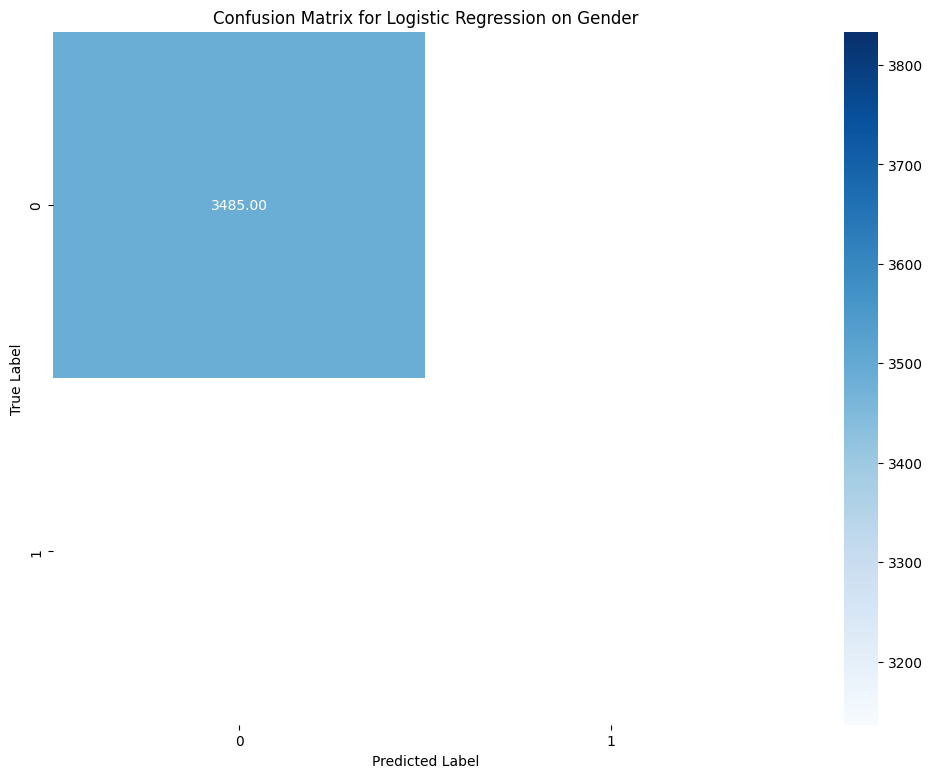

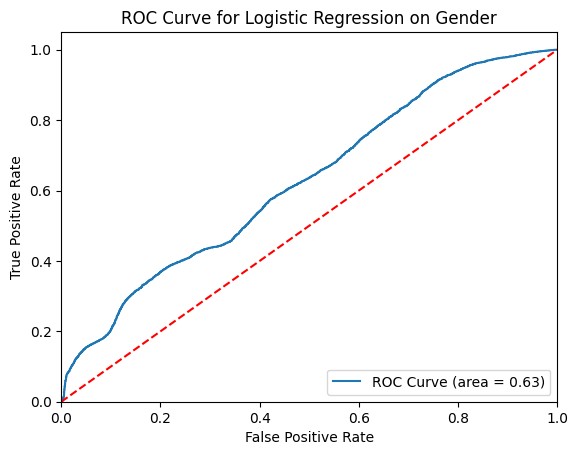

SHAP analysis failed: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'> on Gender with model Logistic Regression

Model: Decision Tree
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best score: 0.6369237816855733
Shapes - Predictions: (11910,), Probabilities: (11910, 2)
Metrics:
Accuracy: 0.5893
Precision: 0.5856
Recall: 0.5893
F1-Score: 0.5833
ROC AUC: 0.5897


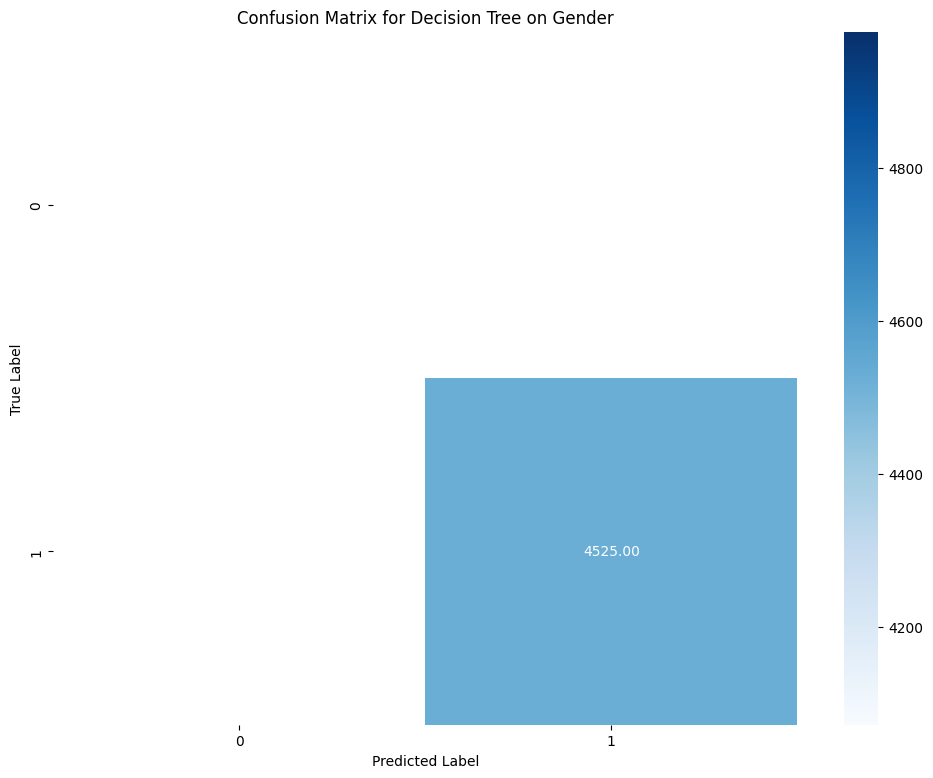

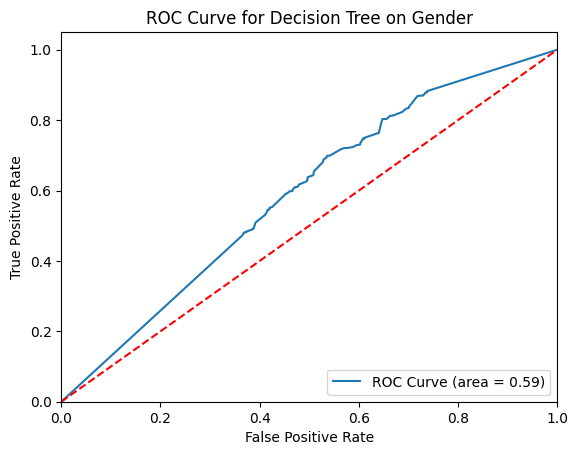


Model: Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
# Gender Identification
X_train, y_train = prepare_features_labels(train_data_ag, 'Gender')
X_test, y_test = prepare_features_labels(test_data_ag, 'Gender')
print("\n--- Gender Identification ---")
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train, y_train, X_test, y_test, model_name=name, task='Gender')

In [ ]:
# Age Identification (Binning ages as needed)
X_train_age, y_train_age = prepare_features_labels(train_data_ag, 'age_binned')
X_test_age, y_test_age = prepare_features_labels(test_data_ag, 'age_binned')
print("\n--- Age Identification ---")
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train_age, y_train_age, X_test_age, y_test_age, model_name=name, task='Age')

In [ ]:
age_classes = combined_data['age_binned'].unique()
age_classes

In [ ]:
# Participant ID Identification
train_data_id, test_data_id = time_series_split(combined_data, test_ratio=0.2)
X_train_id, y_train_id = prepare_features_labels(train_data_id, 'Participant', encode=False)
X_test_id, y_test_id = prepare_features_labels(test_data_id, 'Participant', encode=False)
print("\n--- Participant ID Identification ---")
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train_id, y_train_id, X_test_id, y_test_id, model_name=name, task='Participant ID')

In [ ]:
# Convert IDs to strings
y_train_id = y_train_id.astype(str)

# Now check the unique values
print("Unique values in 'y_train_id':", np.unique(y_train_id))

# Check for NaN values after conversion
print("Number of NaN values in 'y_train_id':", y_train_id.isnull().sum())
